In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Analysis: Capacity

### Import CAHOOTS and EPD-based capacity logs

In [2]:
cahoots = pd.read_csv("../data/busy_log.csv")
epd = pd.read_csv("../data/epd_with_capacity.csv")

#### Convert time-based variables back to datetime objects.

In [3]:
cahoots['calltime'] = pd.to_datetime(cahoots['calltime'], errors='coerce')
cahoots['dispatchtime'] = pd.to_datetime(cahoots['dispatchtime'], errors='coerce')
cahoots['arrivaltime'] = pd.to_datetime(cahoots['arrivaltime'], errors='coerce')
cahoots['endtime'] = pd.to_datetime(cahoots['endtime'], errors='coerce')

In [4]:
epd['calltime'] = pd.to_datetime(epd['calltime'], errors='coerce')
epd['dispatchtime'] = pd.to_datetime(epd['dispatchtime'], errors='coerce')
epd['endtime'] = pd.to_datetime(epd['endtime'], errors='coerce')
epd['time'] = pd.to_datetime(epd['time'], errors='coerce')

#### Separate into groups for statistical tests.
Split, for both EPD and CAHOOTS, by whether cahoots was at capacity or not.

In [5]:
epd_full = epd[epd['cahoots_at_capacity'] == True]['secs_to_arrv']
epd_avail = epd[epd['cahoots_at_capacity'] == False]['secs_to_arrv']

cahoots_full = cahoots[cahoots['capacity'] == True]['secs_to_arrv']
cahoots_avail = cahoots[cahoots['capacity'] == False]['secs_to_arrv']

#### Create results DataFrame to store statistics and p-values from tests

In [6]:
results = pd.DataFrame(columns=['test', 'statistic', 'p_value'])

## Test #1: LEVENES

Use: conduct before t-test to decide whether to assume equal variances.

#### Hypotheses:
- p > 0.05 → variances are similar → use regular t-test
- p < 0.05 → variances differ → use Welch’s t-test (equal_var=False)

**input**: the continuous response variable (`secs_to_arrv`), based on whether the agency is at full or capacity or has availability (separate tests for CAHOOTS and EPD)

**ouput**: W-stat and p-value

In [7]:
from scipy.stats import levene
stat, p_val = levene(epd_full, epd_avail)

results.loc[len(results)] = np.array(['levenes_epd', stat, p_val])

print(f'w-stat = {stat}')
print(f'p = {p_val}')

w-stat = 49.45648208441646
p = 2.0318027002857265e-12


__CONCLUSION: EPD variances *differ* (p = 7.9 * 10^(-16) < 0.05)__

In [8]:
stat, p_val = levene(cahoots_full, cahoots_avail)

results.loc[len(results)] = np.array(['levenes_cahoots', stat, p_val])

print(f'w-stat = {stat}')
print(f'p = {p_val}')

w-stat = 15.222614715763982
p = 9.560222613625285e-05


__CONCLUSION: CAHOOTS variances *differ* (p = 9.6 * 10^(-5) < 0.05)__

## Test #2: T TEST
Use: to determine if there is a significant difference between the means of two groups.

#### Hypotheses:
- H₀: The mean arrival time is the same whether CAHOOTS is at capacity or not.
- H₁: The mean arrival time is different depending on whether CAHOOTS is at capacity.

**input**: the continuous response variable (`secs_to_arrv`), based on whether the agency is at full or capacity or has availability (separate tests for CAHOOTS and EPD)

**ouput**: T-stat and p-value

In [9]:
from scipy.stats import ttest_ind
combined = np.concatenate([epd_full, epd_avail])
mean_comb = combined.mean()
std_comb = combined.std()

epd_full_norm = (epd_full - mean_comb) / std_comb
epd_avail_norm = (epd_avail - mean_comb) / std_comb

t_stat, p_value = ttest_ind(epd_full_norm, epd_avail_norm, equal_var=False)

results.loc[len(results)] = np.array(['t_test_epd', t_stat, p_value])

print("t-stat =", t_stat)
print("p-value =", p_value)

t-stat = 7.153047288973185
p-value = 8.537833892469468e-13


__CONCLUSION: mean EPD arrival time is *different* (p = 3.9 * 10^(-16) < 0.05)__

In [10]:
combined = np.concatenate([cahoots_full, cahoots_avail])
mean_comb = combined.mean()
std_comb = combined.std()

cahoots_full_norm = (cahoots_full - mean_comb) / std_comb
cahoots_avail_norm = (cahoots_avail - mean_comb) / std_comb

t_stat, p_value = ttest_ind(cahoots_full_norm, cahoots_avail_norm, equal_var=False)

results.loc[len(results)] = np.array(['t_test_cahoots', t_stat, p_value])

print("t-stat =", t_stat)
print("p-value =", p_value)

t-stat = 8.765162279529058
p-value = 1.9283186741696096e-18


__CONCLUSION: mean CAHOOTS arrival time is *different* (p = 1.9 * 10^(-18) < 0.05)__

## Test #3: KS TEST

Use: to determine if two distributions differ significantly.

#### Hypotheses:
- H₀: The two samples come from the same continuous distribution (this means the shape, center, spread — everything about the distributions — is statistically indistinguishable)
- H₁: The two samples come from different distributions (this means there’s some difference in the distribution — could be the mean, variance, skew, tails, etc.)

**input**: the continuous response variable (`secs_to_arrv`), based on whether the agency is at full or capacity or has availability (separate tests for CAHOOTS and EPD)

**ouput**: D-stat and p-value

In [11]:
from scipy.stats import ks_2samp
stat, pvalue = ks_2samp(epd_full, epd_avail)

results.loc[len(results)] = np.array(['ks_epd', stat, pvalue])

print(f'd-stat = {stat}')
print(f'p = {pvalue}')

d-stat = 0.0111769419773593
p = 1.4880203644150992e-06


__CONCLUSION: distribution of EPD arrival times do *differ* based on capacity (p = 1.5 * 10^(-8) < 0.05)__

In [12]:
stat, pvalue = ks_2samp(cahoots_full, cahoots_avail)

results.loc[len(results)] = np.array(['ks_cahoots', stat, pvalue])

print(f'd-stat = {stat}')
print(f'p = {pvalue}')

d-stat = 0.07094138091975888
p = 1.415682401495223e-97


__CONCLUSION: distribution of CAHOOTS arrival times do *differ* based on capacity (p = 1.4 * 10^(-97) < 0.05)__

#### Quick look at the results

In [13]:
results

,test,statistic,p_value
0,levenes_epd,49.45648208441646,2.0318027002857265e-12
1,levenes_cahoots,15.222614715763982,9.560222613625285e-05
2,t_test_epd,7.153047288973185,8.537833892469468e-13
3,t_test_cahoots,8.765162279529058,1.9283186741696096e-18
4,ks_epd,0.0111769419773593,1.4880203644150992e-06
5,ks_cahoots,0.07094138091975888,1.415682401495223e-97


### Quick Visualizations
just to help aid interpretations and guide the final plots

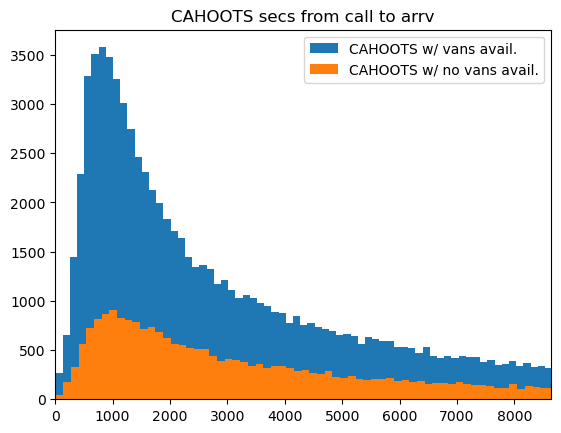

In [14]:
plt.hist(cahoots_avail, bins=2000, label='CAHOOTS w/ vans avail.')
plt.hist(cahoots_full, bins=2000, label='CAHOOTS w/ no vans avail.')
plt.xlim(0, 8640)
plt.legend()
plt.title('CAHOOTS secs from call to arrv')
plt.show()

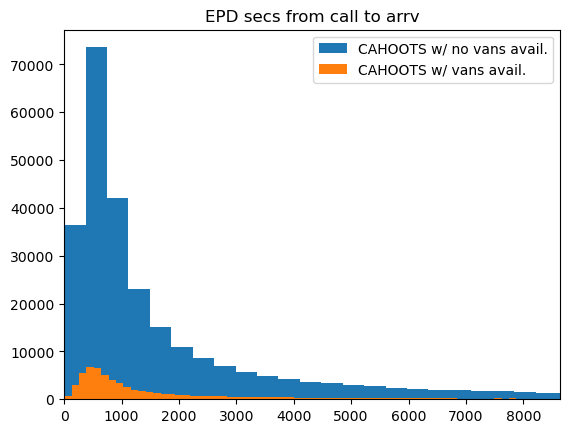

In [15]:
plt.hist(epd_full, bins=2000, label='CAHOOTS w/ no vans avail.')
plt.hist(epd_avail, bins=2000, label='CAHOOTS w/ vans avail.')
plt.xlim(0, 8640)
plt.legend()
plt.title('EPD secs from call to arrv')
plt.show()

### Rough interpretations/ideas based on visualizations & results
results may be impacted because...
- the majority of their data may be while CAHOOTS *doesn't* have vans available
- they take higher call volume then cahoots
- they're more available then cahoots (i.e. more service hours, more vans, more etc.)
- if cahoots is at capacity, EPD has so many units that they may have 10 units all on calls at the *same* time
- cahoots not getting calls if theyre full (i.e. passing them on to EPD)

expanding on the last idea...
- when CAHOOTS is full, only the most urgent calls get through
- if CAHOOTS is at capacity, only higher-priority, more urgent calls are dispatched immediately once a unit becomes free
- this can lead to faster response times for those rare “squeezed in” calls
- when CAHOOTS is not full, they may handle a broader range of lower-priority calls, some of which take longer to get to

#### Another quick look, this time at percentiles and means

In [16]:
print(f'cahoots_full 90th percentile: {np.percentile(cahoots_full, 90)}')
print(f'cahoots_avail 90th percentile: {np.percentile(cahoots_avail, 90)}')

cahoots_full 90th percentile: 15197.5
cahoots_avail 90th percentile: 14515.0


In [17]:
print(f'epd_full 90th percentile: {np.percentile(epd_full, 90)}')
print(f'epd_avail 90th percentile: {np.percentile(epd_avail, 90)}')

epd_full 90th percentile: 8951.300000000017
epd_avail 90th percentile: 8192.0


In [18]:
print(f'cahoots_full mean: {np.mean(cahoots_full)}')
print(f'cahoots_avail mean: {np.mean(cahoots_avail)}')

cahoots_full mean: 6373.30267628094
cahoots_avail mean: 5859.846222563858


In [19]:
print(f'epd_full mean: {np.mean(epd_full)}')
print(f'epd_avail mean: {np.mean(epd_avail)}')

epd_full mean: 3653.3351606975075
epd_avail mean: 3415.5516036565364


### Save `results` DataFrame as a .csv file

In [20]:
results.to_csv('../results/results_capacity.csv')